In [1]:
# liebraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler , MinMaxScaler ,OneHotEncoder ,LabelEncoder
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,precision_score ,recall_score ,f1_score ,confusion_matrix

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [3]:
print(f'shape of the dataset : {df.shape}\n')
print(f'{df.info()}\n')
print(df.describe())

shape of the dataset : (7043, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperle

# Data cleaning

In [5]:
# droping unnessasary columns
df = df.drop('customerID' , axis =1)

# checking null values
print(df.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [6]:
# removing duplicates

print(f'duplicates before cleaning : {df.duplicated().sum()}')
df = df.drop_duplicates()
print(f'duplicates after cleaning : {df.duplicated().sum()}')

duplicates before cleaning : 22
duplicates after cleaning : 0


In [7]:
# outliers removal
num_cols = np.array(['SeniorCitizen','tenure','MonthlyCharges'])

for col in num_cols:
    q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * IQR, q3 + 1.5 * IQR

    # Count outliers before capping and cap them
    outliers_before = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    df[col] = np.clip(df[col], lower_bound, upper_bound)  # Cap the outliers
    outliers_after = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]

    print(f'Outliers in {col}: {outliers_before} capped to bounds. Remaining: {outliers_after}')
    

Outliers in SeniorCitizen: 1141 capped to bounds. Remaining: 0
Outliers in tenure: 0 capped to bounds. Remaining: 0
Outliers in MonthlyCharges: 0 capped to bounds. Remaining: 0


# data preprocessing

In [9]:
# standrdization
print(df.head())
scaler = StandardScaler()
df[['SeniorCitizen','tenure','MonthlyCharges']] = scaler.fit_transform(df[['SeniorCitizen','tenure','MonthlyCharges']])

   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No  

In [10]:
df.to_csv('clean_churn.csv')

In [11]:
# onehot encoding
one_hot_encoding = np.array(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract','PaperlessBilling', 'PaymentMethod'])
df = pd.get_dummies(df, columns = one_hot_encoding ,drop_first = True)

In [12]:
# label encoding
label_encoder = LabelEncoder()
df['Churn'] = label_encoder.fit_transform(df['Churn'])
print(df.head())

   SeniorCitizen    tenure  MonthlyCharges TotalCharges  Churn  gender_Male  \
0            0.0 -1.282728       -1.164135        29.85      0        False   
1            0.0  0.062387       -0.262811       1889.5      0         True   
2            0.0 -1.241967       -0.365914       108.15      1         True   
3            0.0  0.510759       -0.750058      1840.75      0         True   
4            0.0 -1.241967        0.194503       151.65      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3        False           False             False   
4        False           False              True   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                            True  ...                            False   
1                           False  ...                        

In [13]:
# changing the datatype (object to float)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
errors = df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()].index

# Replace missing values with the mean
df['TotalCharges'] = df['TotalCharges'].replace(np.nan, df['TotalCharges'].mean())

# Check if errors is a string, float, or int
if isinstance(errors, (str, float, int)):
    # Convert errors to a float
    float_errors = float(errors)
else:
    # Handle the case where errors is not a string or a number
    print("Error: errors is not a valid value")

Error: errors is not a valid value


In [14]:
# Data spliting
x = df.drop(['Churn'] ,axis =1)
y = df['Churn']
x_train,x_test,y_train,y_test = train_test_split(x,y ,test_size = 0.2 ,random_state =42)

# EDA

C:\Users\Shivmalhar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


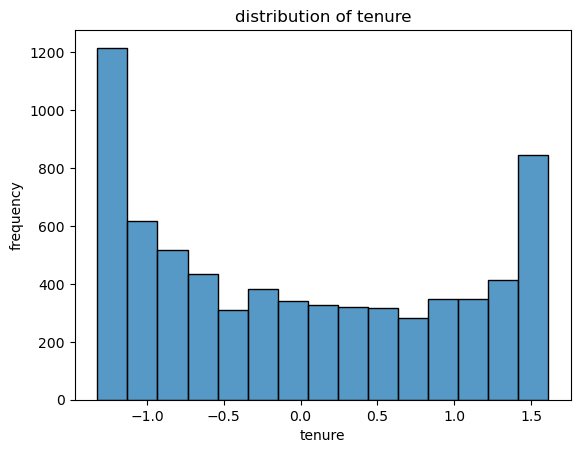

In [16]:
sns.histplot(df['tenure'])
plt.xlabel('tenure')
plt.ylabel('frequency')
plt.title('distribution of tenure')
plt.show()

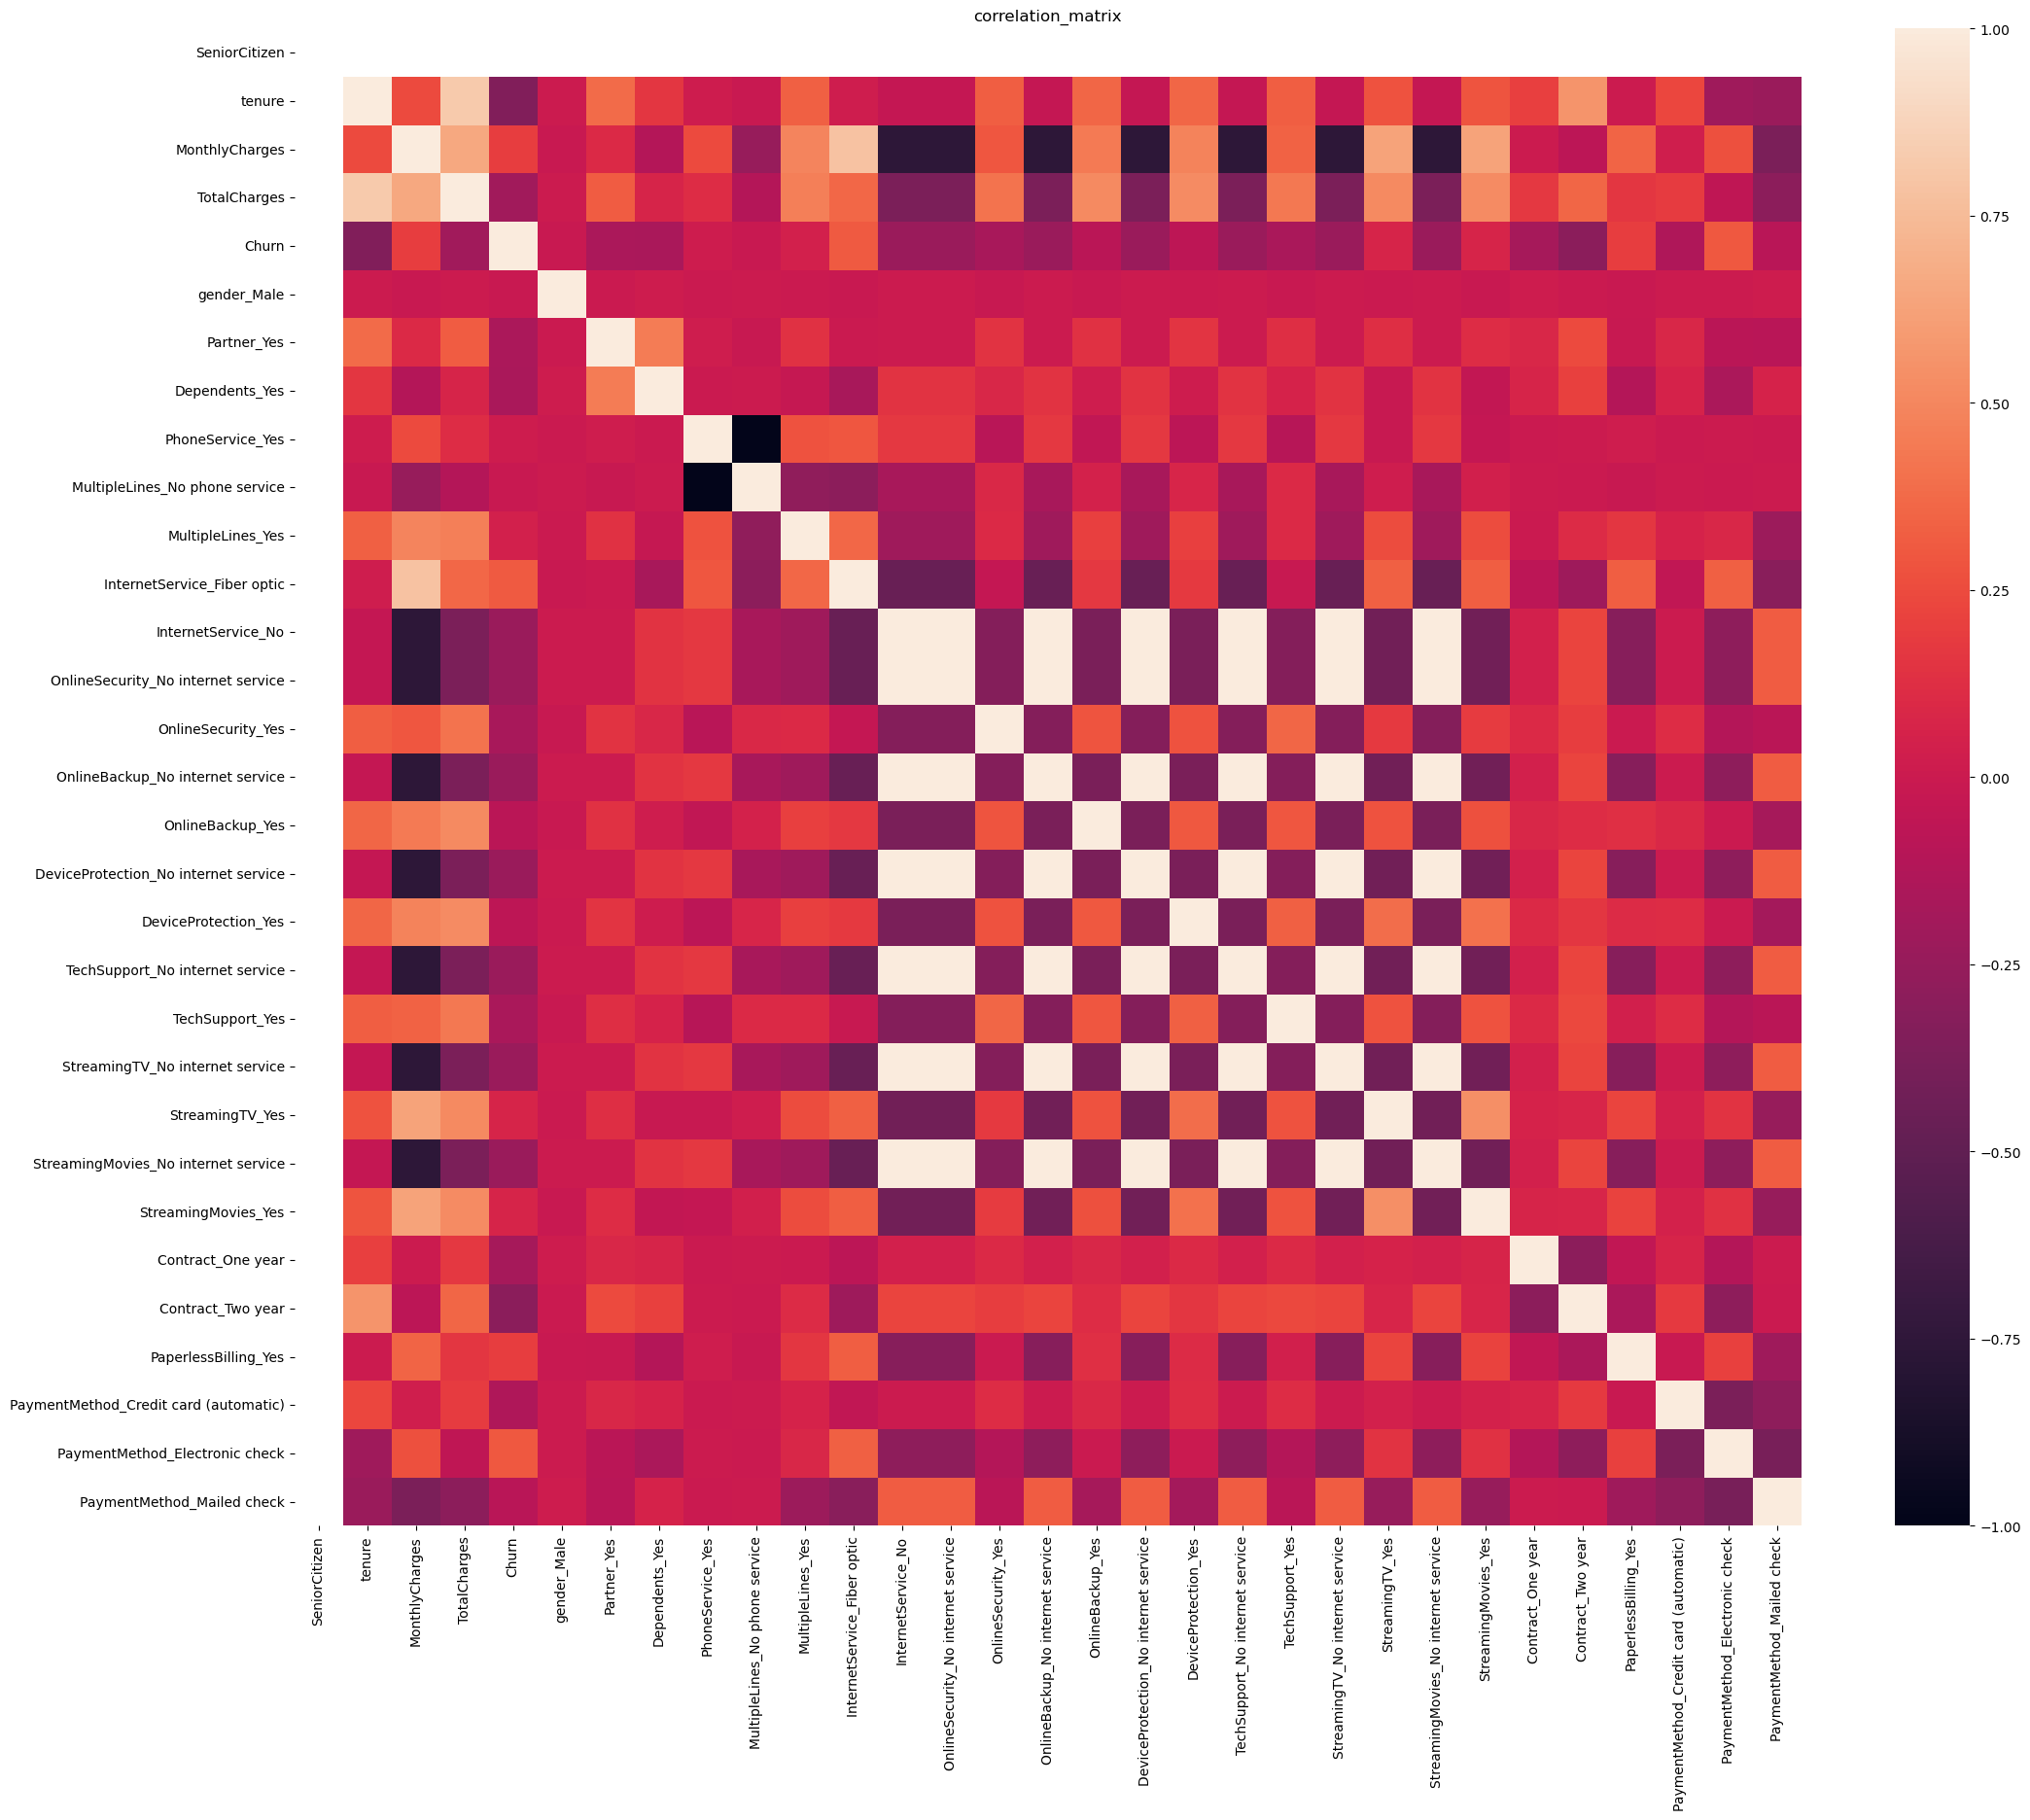

In [17]:
# correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize = (25,20))
sns.heatmap(correlation_matrix)
plt.title('correlation_matrix')
plt.show()

# model buiding

In [19]:
# model building
model = LogisticRegression()
model.fit(x_train , y_train)

# Predictions
y_pred = model.predict(x_test)

# Evaluation metrics
accuracy = accuracy_score(y_test ,y_pred)
precision = precision_score(y_test ,y_pred)
recall = recall_score(y_test ,y_pred)
f1 = f1_score(y_test ,y_pred)
cm = confusion_matrix(y_test ,y_pred)

print(f'Accuracy score : {accuracy}')
print(f'precision score : {precision}')
print(f'recall score : {recall}')
print(f'f1 score : {f1}')
print(f'confusion matrix :\n {cm}')


Accuracy score : 0.797864768683274
precision score : 0.6049382716049383
recall score : 0.5568181818181818
f1 score : 0.5798816568047338
confusion matrix :
 [[925 128]
 [156 196]]


C:\Users\Shivmalhar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
